In [ ]:
import os
import sys
import time
import logging
from typing import Any, Dict
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
from sqlalchemy.engine.url import URL
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import lightgbm as lgb
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.calibration import calibration_curve

# Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

# ------------------------
# DB connection
# ------------------------
def get_db_engine():
    """
    Expect environment variables:
    - PG_HOST
    - PG_PORT
    - PG_DB
    - PG_USER
    - PG_PASSWORD
    """
    host = os.getenv("PG_HOST", "localhost")
    port = os.getenv("PG_PORT", "5432")
    db = os.getenv("PG_DB", "instacart_ecommerce")
    user = os.getenv("PG_USER", "postgres")
    pwd = os.getenv("PG_PASSWORD", "") #input your password
    url = URL.create(
        "postgresql+psycopg2",
        username=user,
        password=pwd,
        host=host,
        port=port,
        database=db,
    )
    engine = create_engine(url, pool_size=20, max_overflow=40, pool_pre_ping=True)
    return engine

ENGINE = get_db_engine()

# ------------------------
# SQL helper
# ------------------------
def run_sql(query: str, params: Dict[str, Any] = None, chunksize: int = None) -> pd.DataFrame:
    """
    Run SQL and return DataFrame. For very large result sets, use chunksize to iterate.
    """
    logging.info("Running SQL (truncated): %s", query[:200].replace("\n", " "))
    with ENGINE.connect() as conn:
        if chunksize:
            dfs = []
            result = conn.execution_options(stream_results=True).execute(text(query), params or {})
            chunks = []
            for chunk in result:
                chunks.append(chunk)
            # fallback if streaming not used
            return pd.DataFrame(chunks)
        else:
            df = pd.read_sql_query(text(query), conn, params=params)
            return df

# ------------------------
# Model persistence
# ------------------------
def save_model(obj, path: str):
    joblib.dump(obj, path)
    logging.info("Saved model to %s", path)

def load_model(path: str):
    return joblib.load(path)

---
### **Pipeline 1 - Next-order recommender (binary ranking model + evaluation)**

**Notes :**

- The SQL produces a sample suitable for iterative model building. You must create materialized aggregates (user/product history tables) on the DB for full production pipelines.
- Negative sampling is simplistic — tune sampling ratio and use hard negatives later (popular items not in user history).

2025-10-27 06:30:09,852 INFO Running SQL (truncated):  -- This query produces a training sample of user-product snapshots and whether product appears in next order. WITH u AS (   SELECT     o.user_id, o.order_id, o.order_number,     SUM(COALESCE(o.days_s
C:\Users\AliKhodabakhsh\AppData\Local\Temp\ipykernel_8332\885557729.py:140: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(len(g), n_neg_per_pos)))


Training until validation scores don't improve for 50 rounds


2025-10-27 06:30:54,070 INFO Saved model to models/nextprod_lgbm.joblib
2025-10-27 06:30:54,084 INFO ROC AUC on holdout: 0.6232
2025-10-27 06:30:54,110 INFO Precision@5: 0.8968  Recall@5: 3.0614
2025-10-27 06:30:54,114 INFO Precision@10: 0.8263  Recall@10: 5.3834
2025-10-27 06:30:54,116 INFO Precision@20: 0.7041  Recall@20: 8.3603


Early stopping, best iteration is:
[12]	training's auc: 0.728251	valid_1's auc: 0.623192


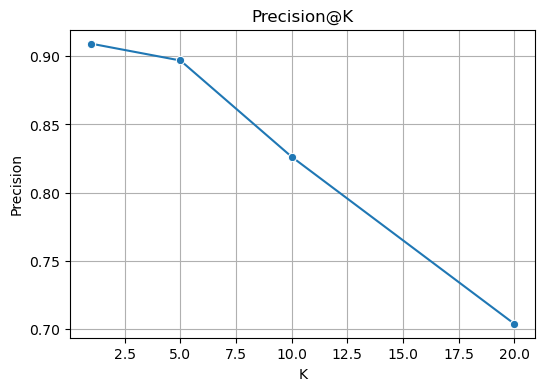

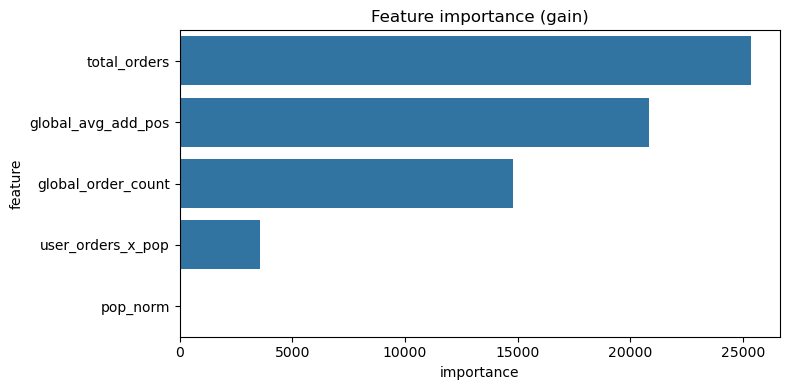

In [2]:

# ------------------------
# Eval metrics (recommendation)
# ------------------------
def precision_at_k_batch(preds_by_user: Dict[int, list], truth_by_user: Dict[int, set], k: int = 10):
    """
    preds_by_user: {user: [prod1, prod2, ... ranked]}
    truth_by_user: {user: {prodA, prodB}}
    """
    precs = []
    for u, preds in preds_by_user.items():
        topk = preds[:k]
        if len(topk) == 0:
            continue
        hits = sum(1 for p in topk if p in truth_by_user.get(u, set()))
        precs.append(hits / k)
    return np.mean(precs) if len(precs) else 0.0

def recall_at_k_batch(preds_by_user: Dict[int, list], truth_by_user: Dict[int, set], k: int = 10):
    recalls = []
    for u, preds in preds_by_user.items():
        topk = preds[:k]
        true = truth_by_user.get(u, set())
        if len(true) == 0:
            continue
        hits = sum(1 for p in topk if p in true)
        recalls.append(hits / len(true))
    return np.mean(recalls) if len(recalls) else 0.0

# ------------------------
# Utility: train/test split by users
# ------------------------
from sklearn.model_selection import train_test_split

def split_by_user(df: pd.DataFrame, user_col='user_id', test_size=0.2, random_state=42):
    users = df[user_col].unique()
    train_users, test_users = train_test_split(users, test_size=test_size, random_state=random_state)
    train_df = df[df[user_col].isin(train_users)].reset_index(drop=True)
    test_df = df[df[user_col].isin(test_users)].reset_index(drop=True)
    return train_df, test_df

# ------------------------
# SQL: build **sampled** training snapshots
# We will not pull the whole 33M dataset in-memory. We'll create a sampling SQL which creates
# snapshot rows: one row per (user, snapshot_order_number, product) where product was ever seen by user up to snapshot.
# For scale, we sample users or limit to popular products.
# ------------------------
SNAPSHOT_SQL_TEMPLATE = """
-- This query produces a training sample of user-product snapshots and whether product appears in next order.
WITH u AS (
  SELECT
    o.user_id, o.order_id, o.order_number,
    SUM(COALESCE(o.days_since_prior_order,0)) OVER (PARTITION BY o.user_id ORDER BY o.order_number) AS days_since_first_order
  FROM public.orders o
  WHERE o.eval_set IN ('prior','train') -- use prior/train for model training
),
ops AS (
  SELECT u.user_id, u.order_id, u.order_number, op.product_id, op.add_to_cart_order, op.reordered
  FROM u
  JOIN public.order_products op ON op.order_id = u.order_id
),
-- Use per-user latest N snapshots to reduce data size (e.g., last 10 orders per user)
recent_snapshots AS (
  SELECT DISTINCT ON (user_id, order_number)
    user_id, order_number
  FROM u
  ORDER BY user_id, order_number DESC
  LIMIT :max_snapshots -- server-side limit controlling sample size (approx)
),
-- Candidate pairs: for each user-snapshot, expand by products the user has ever bought (up to snapshot)
user_products AS (
  SELECT DISTINCT user_id, product_id
  FROM ops
),
snap_prod AS (
  SELECT rs.user_id, rs.order_number AS snapshot_order_number, up.product_id
  FROM recent_snapshots rs
  JOIN user_products up ON up.user_id = rs.user_id
),
-- Label: appears in next order?
label AS (
  SELECT sp.*, CASE WHEN EXISTS (
    SELECT 1 FROM public.orders o_next
    JOIN public.order_products opn ON opn.order_id = o_next.order_id
    WHERE o_next.user_id = sp.user_id AND o_next.order_number = sp.snapshot_order_number + 1 AND opn.product_id = sp.product_id
  ) THEN 1 ELSE 0 END AS label_next
  FROM snap_prod sp
),
-- Join baseline aggregated features (precomputed on DB for scale)
user_feats AS (
  SELECT
    o.user_id,
    COUNT(*) AS total_orders,
    AVG(order_number) AS avg_order_number
  FROM public.orders o
  GROUP BY o.user_id
  -- (You can add more aggregates and store them into a materialized table for production)
),
product_feats AS (
  SELECT
    p.product_id,
    COUNT(op.order_id) AS global_order_count,
    AVG(op.add_to_cart_order)::NUMERIC(5,2) AS global_avg_add_pos
  FROM public.products p
  LEFT JOIN public.order_products op ON op.product_id = p.product_id
  GROUP BY p.product_id
)
SELECT l.user_id, l.product_id, l.snapshot_order_number, l.label_next,
       uf.total_orders, pf.global_order_count, pf.global_avg_add_pos
FROM label l
LEFT JOIN user_feats uf ON uf.user_id = l.user_id
LEFT JOIN product_feats pf ON pf.product_id = l.product_id
LIMIT :limit_rows;
"""

def fetch_training_sample(limit_rows=200000, max_snapshots=50000):
    q = SNAPSHOT_SQL_TEMPLATE
    df = run_sql(q, params={"limit_rows": limit_rows, "max_snapshots": max_snapshots})
    return df

# ------------------------
# Negative sampling and feature augmentation
# ------------------------
def prepare_dataset(df: pd.DataFrame, n_neg_per_pos=3):
    """
    df: contains candidate rows with label_next (0/1) and basic features.
    Keeps positives and samples up to n_neg_per_pos negatives per user-snapshot.
    """
    # ensure types
    df['label_next'] = df['label_next'].astype(int)

    # positives and negatives
    pos = df[df['label_next'] == 1].copy()
    neg = df[df['label_next'] == 0].copy()

    # sample up to n_neg_per_pos negatives per (user_id, snapshot_order_number)
    if not neg.empty:
        sampled_neg = (
            neg
            .groupby(['user_id', 'snapshot_order_number'], group_keys=False)
            .apply(lambda g: g.sample(n=min(len(g), n_neg_per_pos)))
            .reset_index(drop=True)
        )
    else:
        sampled_neg = neg.copy()

    # combine
    ds = pd.concat([pos, sampled_neg], ignore_index=True).reset_index(drop=True)

    # simple popularity normalization (avoid using Series.ptp)
    glo = ds['global_order_count']
    denom = (glo.max() - glo.min())
    if denom == 0 or np.isnan(denom):
        denom = 1.0
    ds['pop_norm'] = (glo - glo.min()) / denom

    # feature interactions
    ds['user_orders_x_pop'] = ds['total_orders'].fillna(0) * ds['pop_norm']

    # fillna
    ds = ds.fillna(0)
    return ds

# ------------------------
# Training & evaluation
# ------------------------
def train_model(df: pd.DataFrame, model_path="models/nextprod_lgbm.joblib"):
    # split by user
    train_df, test_df = split_by_user(df, user_col='user_id', test_size=0.2)

    features = ['total_orders', 'global_order_count', 'global_avg_add_pos', 'pop_norm', 'user_orders_x_pop']
    X_train = train_df[features]
    y_train = train_df['label_next']
    X_test = test_df[features]
    y_test = test_df['label_next']

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    params = {
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'num_threads': 8,
        'verbosity': -1,
        'seed': 42,
    }

    bst = lgb.train(params, train_data, valid_sets=[train_data, val_data], num_boost_round=1000, callbacks=[lgb.early_stopping(stopping_rounds=50)])
    # persist
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    save_model(bst, model_path)

    # Evaluate: basic ROC AUC and ranking-based Precision@K
    proba = bst.predict(X_test, num_iteration=bst.best_iteration)
    auc = roc_auc_score(y_test, proba)
    logging.info("ROC AUC on holdout: %.4f", auc)

    # Build per-user predictions for top-K evaluation:
    preds = test_df[['user_id', 'product_id']].copy()
    preds['score'] = proba
    # get ranked lists
    preds_sorted = preds.sort_values(['user_id', 'score'], ascending=[True, False])
    preds_by_user = preds_sorted.groupby('user_id')['product_id'].apply(list).to_dict()
    truth_by_user = test_df[test_df.label_next==1].groupby('user_id')['product_id'].apply(set).to_dict()

    for k in (5,10,20):
        p_at_k = precision_at_k_batch(preds_by_user, truth_by_user, k=k)
        r_at_k = recall_at_k_batch(preds_by_user, truth_by_user, k=k)
        logging.info("Precision@%d: %.4f  Recall@%d: %.4f", k, p_at_k, k, r_at_k)

    return bst, features, train_df, test_df

# ------------------------
# Visualization
# ------------------------
def plot_precision_by_k(preds_by_user, truth_by_user, ks=(1,5,10,20)):
    results = []
    for k in ks:
        results.append((k, precision_at_k_batch(preds_by_user, truth_by_user, k=k)))
    df = pd.DataFrame(results, columns=['k','precision'])
    plt.figure(figsize=(6,4))
    sns.lineplot(data=df, x='k', y='precision', marker='o')
    plt.title("Precision@K")
    plt.xlabel("K")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()

def plot_feature_importance(bst, features):
    fi = pd.DataFrame({
        "feature": features,
        "importance": bst.feature_importance(importance_type='gain')
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(data=fi, x='importance', y='feature')
    plt.title("Feature importance (gain)")
    plt.tight_layout()
    plt.show()


sample = fetch_training_sample(limit_rows=150000, max_snapshots=50000)
prepared = prepare_dataset(sample, n_neg_per_pos=5)
model, feats, train_df, test_df = train_model(prepared, model_path="models/nextprod_lgbm.joblib")
# build preds_by_user for plots
proba = model.predict(test_df[feats], num_iteration=model.best_iteration)
preds = test_df[['user_id','product_id']].copy()
preds['score'] = proba
preds_sorted = preds.sort_values(['user_id','score'], ascending=[True, False])
preds_by_user = preds_sorted.groupby('user_id')['product_id'].apply(list).to_dict()
truth_by_user = test_df[test_df.label_next==1].groupby('user_id')['product_id'].apply(set).to_dict()
plot_precision_by_k(preds_by_user, truth_by_user)
plot_feature_importance(model, feats)

---
### **Pipeline 2 - Churn prediction & 90-day LTV**
**Notes:**
- I used items as LTV proxy because your dataset lacks price/revenue fields. If you have price or revenue, replace target with dollar amounts.
- The label treats final observed order as churn; for realistic production, use holdout with known future data, not treating last observed as churn outright.

2025-10-27 06:59:00,985 INFO Running SQL (truncated):  WITH u AS (   SELECT      o.user_id,      o.order_id,      o.order_number,     SUM(COALESCE(o.days_since_prior_order, 0)) OVER (PARTITION BY o.user_id ORDER BY o.order_number) AS days_since_first_ord


2025-10-27 06:59:33,266 INFO Feature engineering completed. Columns: ['user_id', 'snapshot_order_number', 'items_in_snapshot', 'days_since_first_order', 'next_days_since_first', 'churn_label', 'items_next_n_days', 'observed_orders', 'recency', 'avg_items_per_order', 'recency_x_avg_items']


Training until validation scores don't improve for 50 rounds


2025-10-27 06:59:34,183 INFO Saved model to models/churn_lgbm.joblib
2025-10-27 06:59:34,221 INFO Churn ROC-AUC: 0.8615


Early stopping, best iteration is:
[53]	training's auc: 0.864698	valid_1's auc: 0.861487
Training until validation scores don't improve for 50 rounds


2025-10-27 06:59:34,607 INFO Saved model to models/ltv_lgbm.joblib
2025-10-27 06:59:34,645 INFO LTV RMSE (items): 3606.6434


Early stopping, best iteration is:
[81]	training's rmse: 53.7436	valid_1's rmse: 60.0553


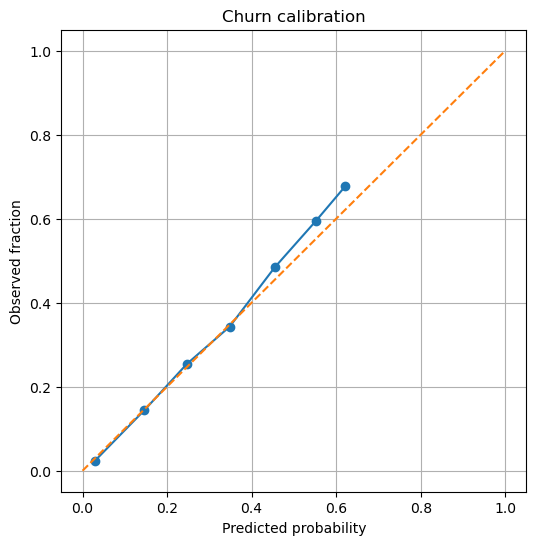

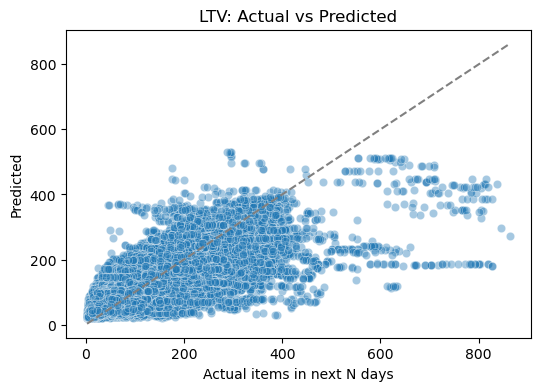

2025-10-27 06:59:35,103 INFO Database connection closed


In [ ]:
# ------------------------
# SQL: compute per-user order timeline and derive churn label and LTV target (items in next N days)
# Simplified to ensure items_next_N_days is correctly computed
# ------------------------
CHURN_LTV_SQL = """
WITH u AS (
  SELECT 
    o.user_id, 
    o.order_id, 
    o.order_number,
    SUM(COALESCE(o.days_since_prior_order, 0)) OVER (PARTITION BY o.user_id ORDER BY o.order_number) AS days_since_first_order
  FROM public.orders o
  WHERE o.eval_set IN ('prior', 'train')
),
user_max_days AS (
  SELECT user_id, MAX(days_since_first_order) AS max_days_since_first
  FROM u
  GROUP BY user_id
),
order_items AS (
  SELECT 
    u.user_id, 
    u.order_id, 
    u.order_number, 
    u.days_since_first_order, 
    COUNT(op.product_id) AS items_in_order
  FROM u
  JOIN public.order_products op ON op.order_id = u.order_id
  GROUP BY u.user_id, u.order_id, u.order_number, u.days_since_first_order
),
next_gaps AS (
  SELECT
    oi.user_id,
    oi.order_number,
    oi.items_in_order,
    oi.days_since_first_order,
    LEAD(oi.days_since_first_order) OVER (PARTITION BY oi.user_id ORDER BY oi.order_number) AS next_days_since_first,
    um.max_days_since_first
  FROM order_items oi
  JOIN user_max_days um ON um.user_id = oi.user_id
),
labeled AS (
  SELECT
    ng.user_id,
    ng.order_number AS snapshot_order_number,
    ng.items_in_order AS items_in_snapshot,
    ng.days_since_first_order,
    ng.next_days_since_first,
    ng.max_days_since_first,
    CASE
      WHEN ng.next_days_since_first IS NOT NULL AND (ng.next_days_since_first - ng.days_since_first_order) >= :churn_days THEN 1
      WHEN ng.next_days_since_first IS NOT NULL AND (ng.next_days_since_first - ng.days_since_first_order) < :churn_days THEN 0
      WHEN ng.next_days_since_first IS NULL AND (ng.max_days_since_first - ng.days_since_first_order) >= :churn_days THEN 1
      ELSE NULL
    END AS churn_label
  FROM next_gaps ng
  WHERE ng.days_since_first_order + :ltv_days <= ng.max_days_since_first
),
future_items AS (
  SELECT 
    l.user_id,
    l.snapshot_order_number,
    l.items_in_snapshot,
    l.days_since_first_order,
    l.next_days_since_first,
    l.churn_label,
    COALESCE(SUM(oi2.items_in_order), 0) AS items_next_n_days  -- Changed to match case exactly
  FROM labeled l
  LEFT JOIN order_items oi2 
    ON oi2.user_id = l.user_id
    AND oi2.days_since_first_order > l.days_since_first_order
    AND oi2.days_since_first_order <= l.days_since_first_order + :ltv_days
  WHERE l.churn_label IS NOT NULL
  GROUP BY l.user_id, l.snapshot_order_number, l.items_in_snapshot, 
           l.days_since_first_order, l.next_days_since_first, l.churn_label
)
SELECT * FROM future_items
LIMIT :limit_rows;
"""

def fetch_churn_ltv_samples(limit_rows=200000, churn_days=30, ltv_days=90):
    try:
        q = CHURN_LTV_SQL
        df = run_sql(q, params={"limit_rows": limit_rows, "churn_days": churn_days, "ltv_days": ltv_days})
        if df.empty:
            logging.warning("Query returned empty DataFrame")
            raise ValueError("No data returned from SQL query")
        # Ensure column name is consistent
        if 'items_next_n_days' not in df.columns:
            logging.error(f"'items_next_n_days' not in DataFrame columns: {df.columns.tolist()}")
            raise KeyError("'items_next_n_days' column missing in query result")
        return df
    except Exception as e:
        logging.error(f"Failed to fetch churn/LTV samples: {e}")
        raise

# ------------------------
# Feature engineering
# ------------------------
def augment_churn_features(df):
    try:
        df = df.copy()
        # user-level proxies: compute prior orders count per user in dataset
        user_counts = df.groupby('user_id')['snapshot_order_number'].nunique().rename('observed_orders')
        df = df.merge(user_counts, left_on='user_id', right_index=True, how='left')
        # recency proxy: days since first to snapshot
        df['recency'] = df['days_since_first_order']
        # frequency proxy: avg items per order so far
        df['cum_items'] = df.groupby('user_id')['items_in_snapshot'].cumsum()
        df['avg_items_per_order'] = df['cum_items'] / df['snapshot_order_number']
        # some interactions
        df['recency_x_avg_items'] = df['recency'] * df['avg_items_per_order']
        df = df.fillna(0)
        df = df.drop(columns=['cum_items'])  # cleanup
        logging.info(f"Feature engineering completed. Columns: {df.columns.tolist()}")
        return df
    except Exception as e:
        logging.error(f"Feature engineering failed: {e}")
        raise

# ------------------------
# Train churn classifier and LTV regressor
# ------------------------
def train_churn_and_ltv(df, churn_model_path="models/churn_lgbm.joblib", ltv_model_path="models/ltv_lgbm.joblib"):
    try:
        # Verify required columns
        required_cols = ['churn_label', 'items_next_n_days', 'user_id', 'snapshot_order_number', 'items_in_snapshot', 'days_since_first_order']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            logging.error(f"Missing required columns: {missing_cols}")
            raise KeyError(f"Missing columns in DataFrame: {missing_cols}")

        # create features
        df_features = augment_churn_features(df)
        # train/test split by user
        train_df, test_df = split_by_user(df_features, user_col='user_id', test_size=0.2)
        feat_cols = ['observed_orders', 'recency', 'avg_items_per_order', 'recency_x_avg_items']

        # churn classifier
        dtrain = lgb.Dataset(train_df[feat_cols], label=train_df['churn_label'])
        dval = lgb.Dataset(test_df[feat_cols], label=test_df['churn_label'])
        churn_params = {
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'seed': 42,
            'verbosity': -1
        }
        churn_model = lgb.train(
            churn_params,
            dtrain,
            num_boost_round=500,
            valid_sets=[dtrain, dval],
            callbacks=[lgb.early_stopping(stopping_rounds=50)]
        )
        save_model(churn_model, churn_model_path)

        # Evaluate churn
        proba = churn_model.predict(test_df[feat_cols], num_iteration=churn_model.best_iteration)
        auc = roc_auc_score(test_df['churn_label'], proba)
        logging.info("Churn ROC-AUC: %.4f", auc)

        # LTV regressor (items_next_n_days)
        dtrain_r = lgb.Dataset(train_df[feat_cols], label=train_df['items_next_n_days'])
        dval_r = lgb.Dataset(test_df[feat_cols], label=test_df['items_next_n_days'])
        ltv_params = {
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'seed': 42,
            'verbosity': -1
        }
        ltv_model = lgb.train(
            ltv_params,
            dtrain_r,
            num_boost_round=500,
            valid_sets=[dtrain_r, dval_r],
            callbacks=[lgb.early_stopping(stopping_rounds=50)]
        )
        save_model(ltv_model, ltv_model_path)

        preds = ltv_model.predict(test_df[feat_cols], num_iteration=ltv_model.best_iteration)
        rmse = mean_squared_error(test_df['items_next_n_days'], preds)
        logging.info("LTV RMSE (items): %.4f", rmse)

        return churn_model, ltv_model, feat_cols, train_df, test_df
    except Exception as e:
        logging.error(f"Training failed: {e}")
        raise

# ------------------------
# Visualizations
# ------------------------
def plot_churn_calibration(model, X_test, y_test, n_bins=10):
    try:
        probs = model.predict(X_test, num_iteration=model.best_iteration)
        frac_pos, mean_prob = calibration_curve(y_test, probs, n_bins=n_bins)
        plt.figure(figsize=(6,6))
        plt.plot(mean_prob, frac_pos, marker='o')
        plt.plot([0,1],[0,1],'--')
        plt.xlabel('Predicted probability')
        plt.ylabel('Observed fraction')
        plt.title('Churn calibration')
        plt.grid(True)
        plt.show()
    except Exception as e:
        logging.error(f"Churn calibration plot failed: {e}")
        raise

def plot_ltv_actual_vs_pred(y_true, y_pred):
    try:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=y_true, y=y_pred, alpha=0.4)
        plt.xlabel("Actual items in next N days")
        plt.ylabel("Predicted")
        plt.title("LTV: Actual vs Predicted")
        plt.plot([y_true.min(), y_true.max()],[y_true.min(), y_true.max()], '--', color='grey')
        plt.show()
    except Exception as e:
        logging.error(f"LTV actual vs predicted plot failed: {e}")
        raise

# ------------------------
# Quick-run
# ------------------------
try:
    sample = fetch_churn_ltv_samples(limit_rows=200000, churn_days=30, ltv_days=90)
    churn_model, ltv_model, feat_cols, train_df, test_df = train_churn_and_ltv(sample)
    # visualization
    plot_churn_calibration(churn_model, test_df[feat_cols], test_df['churn_label'])
    preds = ltv_model.predict(test_df[feat_cols], num_iteration=ltv_model.best_iteration)
    plot_ltv_actual_vs_pred(test_df['items_next_n_days'], preds)
finally:
    ENGINE.dispose()
    logging.info("Database connection closed")

---
## **Pipeline 3 - SKU demand forecasting & picker optimization**

**Notes:**
- This is not a calendar-aware demand forecast. Use pseudo-windows only for short-horizon operational planning. If you need seasonality, attach order_date.
- Picker score is heuristic: tune by measuring actual picker times after moving SKUs.


2025-10-27 07:20:11,852 INFO Running SQL (truncated):  WITH o AS (   SELECT user_id, order_id, order_number   FROM public.orders   WHERE eval_set IN ('prior','train') ), op AS (   SELECT o.order_id, o.order_number, op.product_id   FROM o   JOIN public.or


2025-10-27 07:22:48,911 INFO Saved model to models/sku_forecast_lgbm.joblib
2025-10-27 07:22:48,940 INFO Forecast RMSE (units): 3092.9420
2025-10-27 07:22:48,944 INFO Running SQL (truncated):  SELECT p.product_id, p.product_name, p.aisle_id, p.department_id,        COUNT(op.order_id) AS occurrences,        AVG(op.add_to_cart_order)::NUMERIC(6,2) AS avg_add_pos FROM public.products p JOIN p


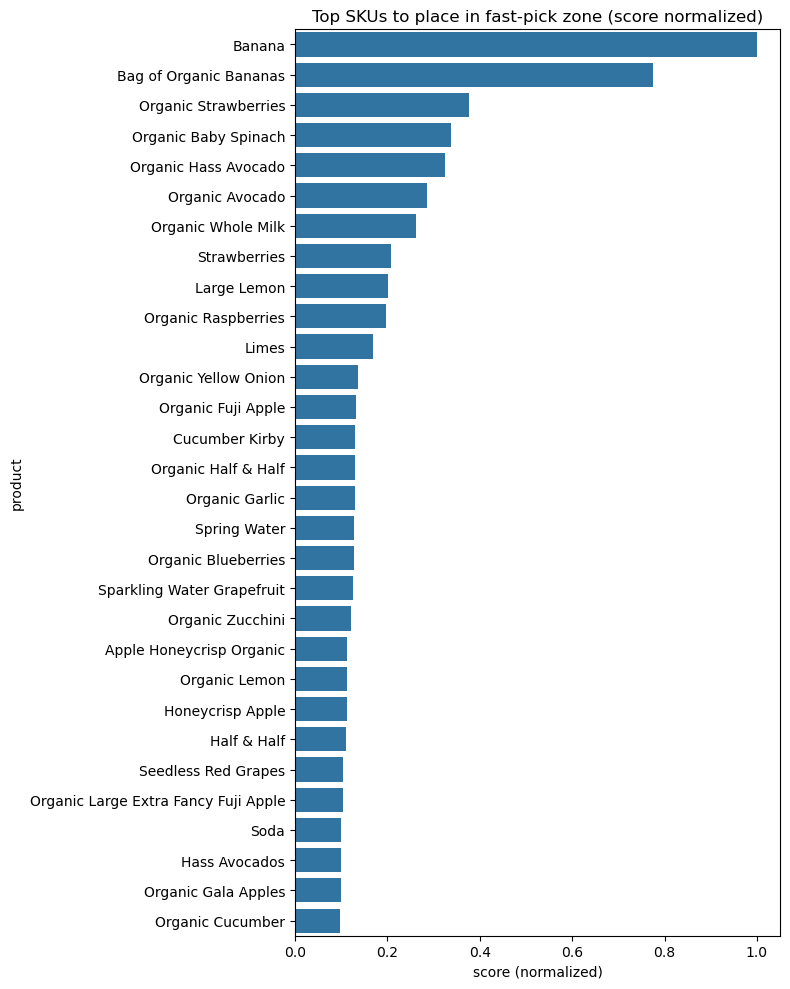

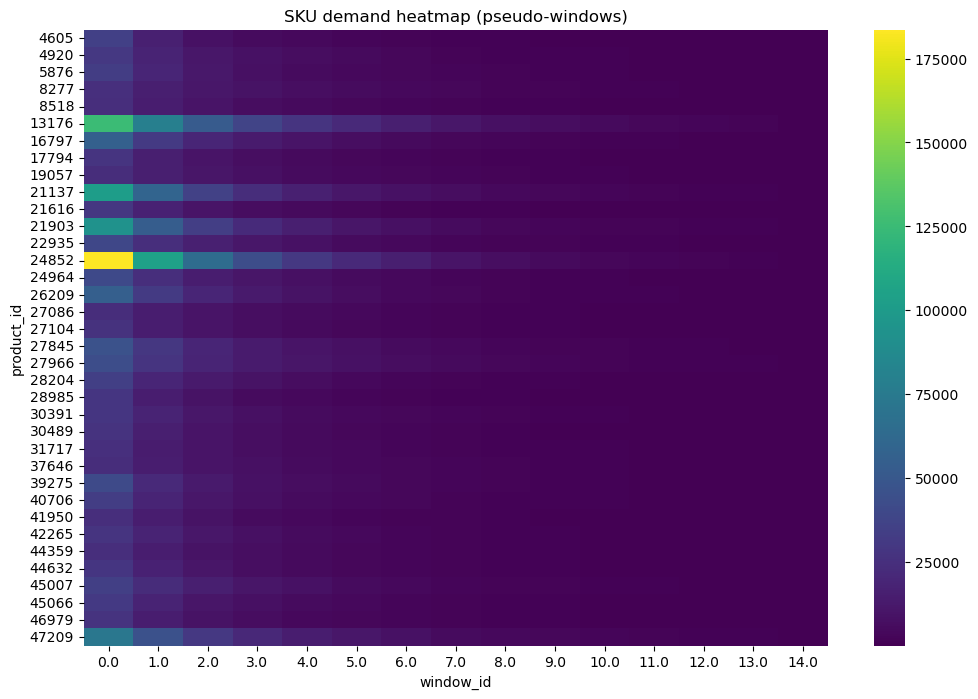

In [20]:
# ------------------------
# SQL: aggregate SKU counts by user-relative pseudo-week (we'll bucket order_number into windows)
# Approach: create window_id = floor((order_number-1)/window_size) per user, then aggregate total sales per SKU per window.
# This avoids global calendar dates; treat window as pseudo-time.
# ------------------------
SKU_WINDOW_SQL = """
WITH o AS (
  SELECT user_id, order_id, order_number
  FROM public.orders
  WHERE eval_set IN ('prior','train')
),
op AS (
  SELECT o.order_id, o.order_number, op.product_id
  FROM o
  JOIN public.order_products op ON op.order_id = o.order_id
),
win AS (
  SELECT
    *,
    floor((order_number - 1) / :window_size) AS window_id
  FROM op
),
sku_window AS (
  SELECT window_id, product_id, COUNT(*) AS units_sold
  FROM win
  GROUP BY window_id, product_id
)
SELECT * FROM sku_window
ORDER BY product_id, window_id
LIMIT :limit_rows;
"""

def fetch_sku_window(window_size=7, limit_rows=500000):
    df = run_sql(SKU_WINDOW_SQL, params={"window_size": window_size, "limit_rows": limit_rows})
    return df

# ------------------------
# Feature engineering: lags per SKU across windows
# ------------------------
def create_time_features(sku_df, max_lag=4):
    """
    sku_df: columns [product_id, window_id, units_sold]
    Produces lag features per (product_id, window_id)
    """
    sku_df_sorted = sku_df.sort_values(['product_id','window_id']).copy()
    out = []
    
    # CRITIQUE: You should ensure 'window_id' is an integer dtype upstream. 
    # If not, the below fix (casting to int) is REQUIRED to prevent TypeError 
    # when using range() but masks potential data quality issues if the IDs 
    # are genuinely non-integer (e.g., 7.5).
    
    for pid, g in sku_df_sorted.groupby('product_id'):
        
        # FIX: Explicitly cast min and max window_id to integer before range()
        min_wid = int(g.window_id.min())
        max_wid = int(g.window_id.max())

        # Corrected line 50:
        g = g.set_index('window_id').reindex(range(min_wid, max_wid + 1), fill_value=0).reset_index()
        
        g['product_id'] = pid
        for lag in range(1, max_lag+1):
            g[f'lag_{lag}'] = g['units_sold'].shift(lag).fillna(0)
        g['rolling_mean_3'] = g[[f'lag_{i}' for i in range(1,4)]].mean(axis=1)
        g['lead_1'] = g['units_sold'].shift(-1).fillna(0) # target
        out.append(g)
    
    df_feat = pd.concat(out, ignore_index=True)
    # drop rows where we don't have enough history (window start)
    df_feat = df_feat[df_feat['window_id'] >= df_feat.groupby('product_id')['window_id'].transform('min') + 1]
    
    return df_feat

# ------------------------
# Train forecast model (one-step ahead)
# ------------------------
def train_forecast(df_feat, product_sample_size=2000, model_path="models/sku_forecast_lgbm.joblib"):
    # sample products to reduce compute if needed
    prods = df_feat['product_id'].unique()
    if len(prods) > product_sample_size:
        sampled_prods = np.random.choice(prods, product_sample_size, replace=False)
        df_feat = df_feat[df_feat['product_id'].isin(sampled_prods)]
    # train/test split by product_id
    prods = df_feat['product_id'].unique()
    train_prods = prods[:int(len(prods)*0.8)]
    test_prods = prods[int(len(prods)*0.8):]
    train = df_feat[df_feat['product_id'].isin(train_prods)]
    test = df_feat[df_feat['product_id'].isin(test_prods)]

    features = [c for c in df_feat.columns if c.startswith('lag_') or c.startswith('rolling_mean_')]
    X_train = train[features]
    y_train = train['lead_1']
    X_test = test[features]
    y_test = test['lead_1']

    dtrain = lgb.Dataset(X_train, y_train)
    dval = lgb.Dataset(X_test, y_test)
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'seed': 42,
        'verbosity': -1
    }
    bst = lgb.train(params, dtrain, valid_sets=[dtrain, dval], num_boost_round=500)
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    save_model(bst, model_path)

    preds = bst.predict(X_test, num_iteration=bst.best_iteration)
    rmse = mean_squared_error(y_test, preds)
    logging.info("Forecast RMSE (units): %.4f", rmse)
    return bst, features, train, test, y_test, preds

# ------------------------
# Picker optimization scoring
# Produce a score = occurrences * (1 / avg_add_to_cart_pos) normalized by department
# ------------------------
PICKER_SQL = """
SELECT p.product_id, p.product_name, p.aisle_id, p.department_id,
       COUNT(op.order_id) AS occurrences,
       AVG(op.add_to_cart_order)::NUMERIC(6,2) AS avg_add_pos
FROM public.products p
JOIN public.order_products op ON op.product_id = p.product_id
GROUP BY p.product_id, p.product_name, p.aisle_id, p.department_id
ORDER BY occurrences DESC
LIMIT :limit_rows;
"""

def fetch_picker_scores(limit_rows=20000):
    df = run_sql(PICKER_SQL, params={"limit_rows": limit_rows})
    df['score'] = df['occurrences'] * (1 / (df['avg_add_pos'] + 1e-6))
    # Normalize using np.ptp instead of df['score'].ptp()
    df['score_norm'] = (df['score'] - df['score'].min()) / (np.ptp(df['score']) + 1e-9)
    return df

# ------------------------
# Visualizations
# ------------------------
def plot_sku_heatmap(df_window, product_id_sample=None):
    """
    df_window columns: product_id, window_id, units_sold
    plot heatmap for sample of products
    """
    if product_id_sample is None:
        product_id_sample = df_window['product_id'].unique()[:50]
    df_small = df_window[df_window['product_id'].isin(product_id_sample)]
    pivot = df_small.pivot_table(index='product_id', columns='window_id', values='units_sold', fill_value=0)
    plt.figure(figsize=(12,8))
    sns.heatmap(pivot, cmap='viridis')
    plt.title("SKU demand heatmap (pseudo-windows)")
    plt.xlabel("window_id")
    plt.ylabel("product_id")
    plt.show()

def plot_picker_top(df_picker, top_n=50):
    top = df_picker.sort_values('score_norm', ascending=False).head(top_n)
    plt.figure(figsize=(8,10))
    sns.barplot(data=top, x='score_norm', y='product_name')
    plt.title("Top SKUs to place in fast-pick zone (score normalized)")
    plt.xlabel("score (normalized)")
    plt.ylabel("product")
    plt.tight_layout()
    plt.show()

# ------------------------
# Quick-run
# ------------------------
sku_window = fetch_sku_window(window_size=7, limit_rows=400000)
df_feat = create_time_features(sku_window, max_lag=4)
bst, features, train, test, y_test, preds = train_forecast(df_feat, product_sample_size=1200, model_path="models/sku_forecast_lgbm.joblib")
# fetch picker scores and plot
picker_df = fetch_picker_scores(limit_rows=10000)
plot_picker_top(picker_df, top_n=30)
plot_sku_heatmap(sku_window, product_id_sample=picker_df['product_id'].head(40).tolist())
